# Example 3: Urban climate adaption

In [1]:
from pyclmuapp import usp_clmu
import matplotlib.pyplot as plt
import os

## usp mode: user forcing mode


workflow
1. initialize
   
    note: the docker container (named **myclmu**) should be running and bind the input_path, output_path, log_path and scripts_path
    if not use the `usp.docker(cmd='run')` to start the container, this will help to bind above paths automatically.
2. check domian
3. check forcing
   
   must define the forcing file
4. run case

### 1 initial case

Here we use the `RUN_TYPE= "branch"` to avoid the repeated spinup phases.

The case (`usp_spinup`) is run for 10 years to spinup the model.

How to get `usp_spinup` ?

```python
usp_spinup = usp.run(
            output_prefix= "_clm.nc",
            case_name = "usp_spinup", 
            RUN_STARTDATE = "2002-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "10",
            RUN_TYPE= "coldstart",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp_spinup
```

In [2]:
# initialize
usp = usp_clmu(
    pwd=os.getcwd(),
    container_type='docker')

# before running container, you need the image
# usp.docker("pull") # to pull the docker image if you don't have it

usp.docker("run") # run the docker container

Folder 'inputfolder' already exists.
Folder 'outputfolder' already exists.
Folder 'logfolder' already exists.
Folder 'scriptsfolder' already exists.
Folder '/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/inputfolder/usp' created successfully!


In [3]:
%%time

# check surface
usp.check_surf() # use the default surface data of London
# use usp.check_surf(usr_surf="sufdata.nc") to use the user provided surface data


# check the domain
# the domain file will be revised according to the surface data if usr_domain is not provided
# do this after check_surf
# because the surfdata should be provided to read the domain file
usp.check_domain()


# check the forcing
# this forcing derived from urban-plumber forcing data
usp.check_forcing(
    usr_forcing="forcing.nc")

usp_or = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example3", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
usp_or

Copying the file forcing.nc to the /Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/inputfolder/usp
CPU times: user 247 ms, sys: 60.6 ms, total: 308 ms
Wall time: 2min 5s


['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example3_clm0_2024-09-24_14-08-54_clm.nc']

### 2 explore the urban adaptation to urban climate

workflow:

1. case2: modify the urban roof albedo --> simulate the white/cooling roof for urban adaptation
   
2. case3: modify the forcing --> simulate global warming
   
3. case4: modify forcing and urban roof albedo --> white roof effect under global warming

**how to change the surface data?**

```python
# change the surface data
usp_clmu.modify_surf(
    action=action,    # dict like result of usp_clmu.check_surf_data() 
                      #or usp_clmu.surfdata_dict
    mode="replace", # optional; the default is "replace"
    usr_surfdata=None, # optional; the path to the new surfdata file, 
                       #the default is "surfdata.nc" provided by pyclmuapp
    surfata_name="surface_replaced.nc" # optional; output file name, 
                                       # the default is "surfdata.nc"
)
```

Args:
- usr_surfdata (str): The path to the user-defined surface data file. The default is None.
- action (dict): The dictionary of the revised surface data for the urban surface parameters. The default is None, which means no action.
- mode (str): The mode for the revision. The default is "replace".
- surfata_name (str): The name of the revised surface data file. The default is "surfdata.nc".
- urban_type (int): The type of the urban surface. The default is 2. 0 is for TBD urban, 1 is for HD urban, and 2 is for MD urban.

In [4]:
%%time

# modify the surface
usp.modify_surf(action={"ALB_ROOF_DIR":0.2}, surfata_name="surface_modfied.nc", mode="add")
usp_surf = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example3", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )

# modify the forcing
usp.modify_forcing(action={"Tair": 1}, mode="add", forcing_name="forcing_replaced.nc")
usp_warming_surf = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example3", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )

# recover the surface
usp.modify_surf(action={"ALB_ROOF_DIR":-0.2}, surfata_name="surface_modfied.nc", mode="add")
usp_warming = usp.run(
            output_prefix= "_clm.nc",
            case_name = "example3", 
            RUN_STARTDATE = "2012-01-01",
            STOP_OPTION = "nyears", 
            STOP_N = "2",
            RUN_TYPE= "branch",
            RUN_REFCASE= "usp_spinup", # the case name of the spinup run
            RUN_REFDATE= "2012-01-01",
            iflog = True,
            logfile = "log.log",
            run_tyep="usp-exec"#"case", when docker container is not start)
        )
# recover the forcing
usp.modify_forcing(action={"Tair": -1}, mode="add", forcing_name="forcing_replaced.nc")

CPU times: user 782 ms, sys: 216 ms, total: 999 ms
Wall time: 3min 32s


In [5]:
print(usp_or)
print(usp_warming)
print(usp_surf)
print(usp_warming_surf)

['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example3_clm0_2024-09-24_14-08-54_clm.nc']
['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example3_clm0_2024-09-24_14-12-26_clm.nc']
['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example3_clm0_2024-09-24_14-10-07_clm.nc']
['/Users/user/Documents/GitHub/pyclmuapp/docs/notebooks/usp/outputfolder/lnd/hist/example3_clm0_2024-09-24_14-11-17_clm.nc']


**use `usp_clmu.nc_view()` to read the output files**

In [6]:
ds_or_usp = usp.nc_view(usp_or[0])
ds_warming_usp = usp.nc_view(usp_warming[0])
ds_surf_usp = usp.nc_view(usp_surf[0])
ds_warming_surf_usp = usp.nc_view(usp_warming_surf[0])

### 3 Plotting

Note: ploting with time will need the `nc-time-axis` package, which can be installed by `pip install nc-time-axis` or `conda install nc-time-axis`

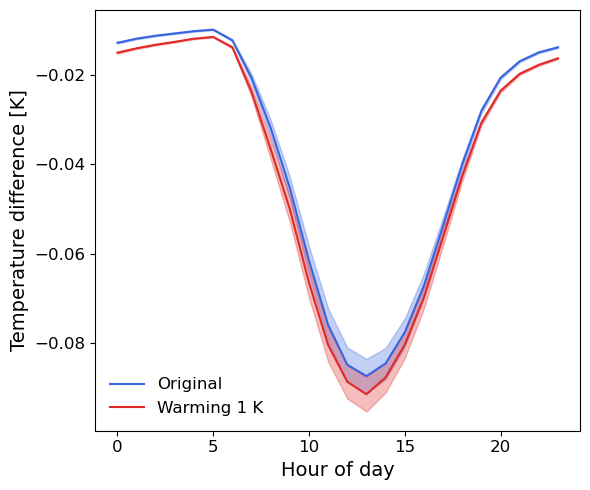

In [7]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

# plot the original
dd = (ds_surf_usp['TSA']-ds_or_usp['TSA']).isel(gridcell=0).groupby('time.hour')
mean = dd.mean('time')
var = dd.var('time')
mean.plot(ax=ax, label='Original', color='#3964DF')
ax.fill_between(mean['hour'].values, mean - var, mean + var, alpha=0.3, color='#3964DF')

# plot the warming
dd = (ds_warming_surf_usp['TSA']-ds_warming_usp['TSA']).isel(gridcell=0).groupby('time.hour')
mean = dd.mean('time')
var = dd.var('time')
mean.plot(ax=ax, label='Warming 1 K', color='#E02927')
ax.fill_between(mean['hour'].values, mean - var, mean + var, alpha=0.3, color='#E02927')

ax.set_xlabel('Hour of day', fontsize=14)
ax.set_ylabel('Temperature difference [K]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('')
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig('figs/example3_usp.pdf', dpi=300)
plt.show()

In [8]:
usp.case_clean(case_name="example3")

**stop and remove the container**

In [9]:
usp.docker("stop")
usp.docker("rm")